In [80]:
import os
import torch
import numpy as np

### Auxiliary Functions 

In [81]:
import pydicom 
from pydicom.uid import UID
from pydicom.uid import generate_uid

def anonymize_dicom(dicom, SeriesDescription, PatientID, SeriesNumber=0, StudyDate='20000914', ProtocolName='Anonymized', SeriesInstanceUID='Anonymized', StudyInstanceUID='Anonymized'):

    dicom.PatientName = 'DENT_%s'%(PatientID)

    dicom.StudyDate           = StudyDate
    dicom.PatientAge          = '030Y'
    dicom.PatientBirthDate    = '19600101'
    dicom.PatientID           = PatientID
    
    dicom.AcquisitionDateTime = '%s174857.910000'%(StudyDate)
    dicom.StudyDescription    = 'TemporalResolutionEnhancement'
    dicom.SeriesDescription   = SeriesDescription
    dicom.StudyInstanceUID    = StudyInstanceUID
    dicom.SeriesInstanceUID   = SeriesInstanceUID
    dicom.SOPInstanceUID      = generate_uid()
    dicom.SeriesNumber        = '%.4d'%(SeriesNumber)
    dicom.ProtocolName        = ProtocolName
    
    dicom[0x0008, 0x103e].value = ProtocolName
    dicom[0x0018, 0x1030].value = ProtocolName


    return dicom
    
def PercentileRescaler(Arr):
    minval=np.percentile(Arr, 0, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    maxval=np.percentile(Arr, 100, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)

    if minval==maxval:
        print("Zero Detected")
    Arr=(Arr-minval)/(maxval-minval)
    Arr=np.clip(Arr, 0.0, 1.0)
    return Arr, minval, maxval

def RestoreRescaler (Arr, minval, maxval):
    arr= Arr*(maxval-minval)+(minval)
    arr = np.clip(arr, minval, maxval)
    return arr

def load_sample_dicom():
        
    import glob 
    import pydicom 
    
    dicom_folder_sample = './dicoms/SAMPLE_SUBJECT/series7001-Body/*'

    dicom_paths = sorted(glob.glob(dicom_folder_sample))

    dicoms = [pydicom.read_file(dicom_path) for dicom_path in dicom_paths]

    pixel_arrays = read_dicoms(dicoms)

    return dicoms, pixel_arrays, dicom_paths

def read_dicoms(dicoms):

    import numpy as np 
    
    pixel_arrays = None
    for dicom in dicoms: 
        pixel_array  = dicom.pixel_array 

        if pixel_arrays is None:
            pixel_arrays = pixel_array[None]
        else:
            pixel_arrays = np.concatenate((pixel_arrays, pixel_array[None]))

    return pixel_arrays 
        

#### Prepare model and load sample data 

In [82]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'

device = torch.device('cuda')

from model.VFIT_B import UNet_3D_3D

model = UNet_3D_3D(n_inputs=4, joinType="concat")

model = torch.nn.DataParallel(model).to(device)

print("#params" , sum([p.numel() for p in model.parameters()]))


#params 29082065


In [47]:
dicoms, pixel_arrays, dicom_paths= load_sample_dicom()

In [88]:
load_from = '/mnt/alp/Users/Manuel/code/Video-Frame-Interpolation-Transformer/checkpoints_large_dataset_2022_10_03/model_best.pth'
model_dict = model.state_dict()
model.load_state_dict(torch.load(load_from)["state_dict"] , strict=True)
model.eval();

In [90]:
data = np.load('/mnt/alp/Research Data Sets/TemporalResolutionEnhancement/FromFIRE/data.npy')

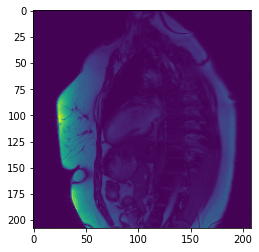

In [95]:
plt.imshow(data[:,:,0,0])

In [ ]:
pixel_arrays = data[:,:,0].transpose(())

#### Prediction 

In [74]:
from torchvision import transforms

T = transforms.Compose([transforms.ToTensor()])


with torch.no_grad():

    interpolated = None 
    original = None 
    for center_phase_idx in range(len(pixel_arrays)):

        if center_phase_idx < len(pixel_arrays) - 1:
            sample_ids = [center_phase_idx-2, center_phase_idx-1, center_phase_idx, center_phase_idx+1]
        else:
            sample_ids = [center_phase_idx-2, center_phase_idx-1, center_phase_idx, 0]

        # the model was trained using 16-bit images extracted from the DICOM 
        # they were then 0-1 normalized. Here we perform equivalent operation:
        samples, minval, maxval = PercentileRescaler(pixel_arrays[np.array(sample_ids)]) # normalize 16-bit array to 0-1

        # the training data was extracted as .png to enable visualization, which requires cv2 
        # here we avoid the use of the cv2 module (can be painful to install), and simply simulate RBG image 
        # (not ideal, we could-retrain model in a better way to avoid these operations)
        samples = (255*np.repeat(samples[...,None], 3, -1)).astype('uint8') 

        # Now we loop frame-by-brame. This could be parallelize, but for now assume batch = 1 
        images = [T(samples[tk])[None] for tk in range(4)]
        images = [img.cuda() for img in images]

        torch.cuda.synchronize()
        
        out = model(images) # interpolate image at t + 0.5
        out = np.clip(out.detach().cpu().numpy(), 0, 1)
        out = RestoreRescaler(out, minval, maxval)

        prev_phase = pixel_arrays[center_phase_idx-1][None]
        next_phase_interpolated = out[:,0]
        
        if interpolated is None:
            original     = prev_phase
            interpolated = next_phase_interpolated
        else:
            original     = np.concatenate((original, prev_phase))
            interpolated = np.concatenate((interpolated, next_phase_interpolated))
        torch.cuda.synchronize()
        

/home/mmorales/miniconda3/envs/DL2/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


#### Generate New DICOM 

In [75]:
TriggerTimes = [dicom.TriggerTime.real for dicom in dicoms]

reconstructed_temporal_resolution = np.diff(TriggerTimes).mean()

In [76]:
def export_dicom_slice_2foldgain(dicoms, dicom_paths, pixel_arrays_original, pixel_arrays_interpolated,
                                 StudyInstanceUID, SeriesInstanceUID_1, SeriesInstanceUID_2,
                                 SubjectID, dirname_out):

    os.makedirs(os.path.join(dirname_out, 'interpolated'), exist_ok=True)
    os.makedirs(os.path.join(dirname_out, 'original'), exist_ok=True)
    
    TriggerTimes = [dicom.TriggerTime.real for dicom in dicoms]

    reconstructed_temporal_resolution = np.diff(TriggerTimes).mean()



    for InstanceIndex, (DicomFileName, TriggerTime) in enumerate(zip(dicom_paths, TriggerTimes)):
        
        # original dicom as reference
        dicom = dicoms[InstanceIndex]

        dicom_original = anonymize_dicom(dicom, SeriesDescription=SubjectID, PatientID=SubjectID, 
                                         SeriesNumber=1, ProtocolName='original', 
                                         StudyInstanceUID=StudyInstanceUID, SeriesInstanceUID=SeriesInstanceUID_1)
        dicom_original.PixelData = pixel_arrays_original[InstanceIndex].tobytes() 
        dicom_original.save_as(os.path.join(dirname_out, 'original', os.path.basename(DicomFileName)))
       

        # Original Phase at t
        dicom_interpolated = anonymize_dicom(dicom, SeriesDescription=SubjectID, PatientID=SubjectID, 
                                             SeriesNumber=2, ProtocolName='DENT_interpolated', 
                                             StudyInstanceUID=StudyInstanceUID, SeriesInstanceUID=SeriesInstanceUID_2)
        dicom_interpolated.CardiacNumberOfImages = "%d"%(len(pixel_arrays))
        dicom_interpolated.TriggerTime           = str(TriggerTime)
        dicom_interpolated.PixelData             = pixel_arrays_original[InstanceIndex].tobytes() 

        dicom_name = os.path.basename(DicomFileName).strip('.dcm')
        dicom_name += '1.dcm'
        dicom_interpolated.save_as(os.path.join(dirname_out, 'interpolated', dicom_name))
        
        # Insert new cardiac DENT-Interpolated Phase at t + 0.5 * dt

        dicom_interpolated = anonymize_dicom(dicom, SeriesDescription=SubjectID, PatientID=SubjectID, 
                                             SeriesNumber=2, ProtocolName='DENT_interpolated', 
                                             StudyInstanceUID=StudyInstanceUID, SeriesInstanceUID=SeriesInstanceUID_2)

        dicom_interpolated.CardiacNumberOfImages = "%d"%(len(pixel_arrays))
        dicom_interpolated.TriggerTime           = str(TriggerTime + reconstructed_temporal_resolution/2.0) # shift by dt/2
        dicom_interpolated.PixelData             = pixel_arrays_interpolated[InstanceIndex].tobytes() 

        dicom_name = os.path.basename(DicomFileName).strip('.dcm')
        dicom_name += '2.dcm'
        dicom_interpolated.save_as(os.path.join(dirname_out, 'interpolated', dicom_name)) 

    return None 

In [77]:
dirname_out = '/mnt/alp/Users/Manuel/code/DENT/dicoms_interpolated'

In [78]:
SubjectID = 'INLINE_TEST_2Fold_gain'
StudyInstanceUID    = generate_uid()
SeriesInstanceUID_1 = generate_uid()
SeriesInstanceUID_2 = generate_uid()

In [79]:
export_dicom_slice_2foldgain(dicoms, dicom_paths, original.astype('uint16'), interpolated.astype('uint16'),
                                 StudyInstanceUID, SeriesInstanceUID_1, SeriesInstanceUID_2,
                                 SubjectID, dirname_out)

/home/mmorales/miniconda3/envs/DL2/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning: The value length (18) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/mmorales/miniconda3/envs/DL2/lib/python3.7/site-packages/pydicom/valuerep.py:290: UserWarning: The value length (17) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
